In [1]:
# from network.Gamma2DCropPaste import StackTPredict, UNet, StackSequenceT , Gamma2DCropPaste, Gamma2DNet
from network.mapGeneratorNet import LSTMNet, Generator, GeneratorPredict

import torch
import numpy as np 
from common.readFiles import *
from common.evaluateModelTools import *
from matplotlib import pyplot as plt
from policy.PytorchTraining import PytorchRunner
import matplotlib.ticker as ticker
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
params = {'legend.fontsize': 16,
          'figure.figsize': (15, 5),
         'axes.labelsize': 16,
         'axes.titlesize':16,
         'xtick.labelsize':16,
         'ytick.labelsize':16}
plt.rcParams.update(params)

In [5]:
map_x = 5
variables = ["source_pos", "source_region", "X_input", "source_concentration", 
             "water_flow_force", "source_inside", "distance_map", "source_detect",
             "source_distance", "agent_action", "agent_position", "centroids", "source_detect"]

datas = []
for map_x in [5, 10, 20]:
    path = "../output/data/processedData/voroni/stochastic/{}/".format(map_x)
    datas.append(getData(path, variables) )

In [11]:
map_x = 5
env_arg = {
    "predict_map_shape": (map_x, map_x),
    
    "directions": torch.tensor([[0, -1], [1, 0], [0, 1], [-1, 0]]),
    "dt":5,
    
    "feature_dim":3,
}

model_arg = {
    "T":5,
    "k_tap":7,
    "T_range":5,
    "T_threshold": 0,
    "up" : 1,
    "skip_connection":False,
    "mu": 1,
}
runner_arg = {
    "new_loss" : True,
    "regularizer_constant": 0.01,
    "accuracy_range":0,
    "folder_path":"../output/ReportModel/stochastic/{}outOf{}/",
    "name":"LSTM"
}

In [12]:
LSTM_model = GeneratorPredict(env_arg, model_arg).to(DEVICE)
pytorch_total_params = sum(p.numel() for p in LSTM_model.parameters())
pytorch_total_params

73402

In [13]:
map_x = 5
new_loss = True
regularizer_constant = 0

path = "../output/ReportModel/stochastic/evaluate/modelWeight/model_{}_{}_{}.pth".format(map_x, new_loss, regularizer_constant)
model = GeneratorPredict(env_arg, model_arg).to(DEVICE)
model = getModel(model, path)

In [14]:
def calculateError():
    def findAngle(A, B):
        cos_between = torch.sum(A * B, axis=-1) / (torch.norm(B, dim=-1) * torch.norm(A, dim=-1))
        error_angle = torch.arccos(cos_between)
        # error_angle[error_angle > np.pi/2] = np.pi - error_angle[error_angle > np.pi/2]
        error_angle[torch.isnan(error_angle)] = -1  # bsize, time_len
        return error_angle

    mask_inside_with_detect = source_inside * source_detect
    mask_inside_no_detect = source_inside * (1 - source_detect)
    mask_outside_with_detect = (1 - source_inside) * source_detect
    mask_outside_no_detect = (1 - source_inside) * (1 - source_detect)

    masks = [mask_inside_with_detect, mask_inside_no_detect, mask_outside_with_detect, mask_outside_no_detect]
    error_distance_list, error_angle_list = [], []

    predict_centroid = centroids[torch.argmax(normalized_predict, dim=-1)].to(DEVICE)  # bsize, time_len, 2
    # predict_centroid = agent_pos + predict_centroid  # bsize, time_len, 2

    # error distance
    error_distance = torch.nn.PairwiseDistance(p=2)(predict_centroid.reshape(-1, 2),
                                                    source_pos.reshape(-1, 2)).reshape(
        source_pos.shape[:-1])  # bsize, time_len
    error_angle = findAngle(predict_centroid, source_pos)  # bsize, time_len

    for mask in masks:
        distance_mask, angle_mask = mask, mask * (error_angle >= 0)

        avg_error_distance = torch.sum(error_distance * distance_mask) / torch.sum(distance_mask)
        avg_error_angle = torch.sum(error_angle * angle_mask) / torch.sum(angle_mask)

        error_distance_list.append(avg_error_distance.to('cpu').item())
        error_angle_list.append(avg_error_angle.to('cpu').item())

    return np.array(error_distance_list), np.array(error_angle_list)

def calculateSourceDistance():
    return torch.cdist(source_pos, torch.tensor([[0,0]], dtype=torch.float)).squeeze(-1)

In [8]:
# new_loss = False
# regularizer_constant = 0
# up = 1
# map_x = 5

# model_arg['up'] = up
# runner_arg["regularizer_constant"] = regularizer_constant
# runner_arg["new_loss"] = new_loss



# #get data
# source_pos, source_region, X_input, source_concentration, water_flow_force, source_inside, distance_map, source_detect, source_distance, agent_action, agent_position, centroids, source_detect = datas[0]

# #get model
# path = "../output/ReportModel/stochastic/evaluate/modelWeight/model_{}_{}_{}.pth".format(map_x, new_loss, regularizer_constant)

# LSTM_model = GeneratorPredict(env_arg, model_arg).to(DEVICE)
# LSTM_model = getModel(LSTM_model, path)

# #get runner
# LSTM_runner = PytorchRunner(runner_arg=runner_arg)
# LSTM_runner.modelInitialize(LSTM_model)


# LSTM_runner.dataInitialize([X_input, agent_action, distance_map, source_region, source_pos, source_inside, source_detect])
# LSTM_runner.logDataInitialize([source_concentration, water_flow_force, centroids])

# X_input, agent_action, distance_map_final, source_region, source_pos, source_inside, source_detect = LSTM_runner.test_data
# # test_X_input, test_agent_action, test_distance_map_final, test_source_region, test_source_pos, test_source_inside, test_source_detect = test_data


# LSTM_runner.valid, LSTM_runner.full_valid = LSTM_runner.X_input_valid_final_test, LSTM_runner.X_full_input_valid_final_test
# mask, error_distance, error_angle, source_distance, valid = LSTM_runner.runEp(LSTM_runner.test_data, log=LSTM_runner.test_log, evaluate = True)


# # error_distance_list, error_angle_list = calculateError()
# # source_distance = calculateSourceDistance()



In [15]:

def getPlot(new_loss, map_x, regularizer_constant, inside, distance = True):
    path = "../output/ReportModel/stochastic/evaluate/modelWeight/model_{}_{}_{}.pth".format(map_x, new_loss, regularizer_constant)
    # path = "../output/ReportModel/stochastic/reinforce/modelWeight/model_{}_{}_{}.pth".format(map_x, new_loss, regularizer_constant)
    
    up = min(map_x // 5, 3)

    model_arg['up'] = up
    runner_arg["regularizer_constant"] = regularizer_constant
    runner_arg["new_loss"] = new_loss
    LSTM_model = GeneratorPredict(env_arg, model_arg).to(DEVICE)
    LSTM_model = getModel(LSTM_model, path)

    #get runner
    LSTM_runner = PytorchRunner(runner_arg=runner_arg)
    LSTM_runner.modelInitialize(LSTM_model)

    variables = ["source_pos", "source_region", "X_input", "source_concentration", 
             "water_flow_force", "source_inside", "distance_map", "source_detect",
             "source_distance", "agent_action", "agent_position", "centroids", "source_detect"]
    
    data_index = min((map_x//5 - 1), 2)
    source_pos, source_region, X_input, source_concentration, water_flow_force, source_inside, distance_map, source_detect, source_distance, agent_action, agent_position, centroids, source_detect = datas[data_index]

    LSTM_runner.dataInitialize([X_input, agent_action, distance_map, source_region, source_pos, source_inside, source_detect])
    LSTM_runner.logDataInitialize([source_concentration, water_flow_force, centroids])

    X_input, agent_action, distance_map_final, source_region, source_pos, source_inside, source_detect = LSTM_runner.test_data
    # test_X_input, test_agent_action, test_distance_m
    # ap_final, test_source_region, test_source_pos, test_source_inside, test_source_detect = test_data


    LSTM_runner.valid, LSTM_runner.full_valid = LSTM_runner.X_input_valid_final_test, LSTM_runner.X_full_input_valid_final_test
    mask, error_distance, error_angle, source_distance, valid = LSTM_runner.runEp(LSTM_runner.test_data, log=LSTM_runner.test_log, evaluate = True)
    # return error_distance
    mask, error_distance, error_angle, source_distance, valid = mask.to('cpu'), error_distance.to('cpu'), error_angle.to('cpu'), source_distance.to('cpu'), valid.to('cpu')
    
    if isinstance(inside, tuple):
        evaluate_mask = (mask[inside[0]] + mask[inside[1]]).type(torch.bool)    
    else: evaluate_mask = mask[inside].type(torch.bool)
    evaluate_x = source_distance[evaluate_mask]
    if distance:
        evaluate_y = error_distance[evaluate_mask]
    else: evaluate_y = error_angle[evaluate_mask]
    
    # return evaluate_x, evaluate_y
    x,y = kernelSmooth(evaluate_x, evaluate_y)
    
    return x, y



In [41]:
i = 0
new_loss, map_x, regularizer_constant, inside = new_losses[i], map_xs[i], regularizer_constants[i], insides[i]

angle_x, angle_y = getPlot(new_loss, map_x, regularizer_constant, inside, distance=False)

distance_x, distance_y = getPlot(new_loss, map_x, regularizer_constant, inside)

tensor(1.) tensor(1.)
tensor(1.) tensor(1.)
tensor(1.) tensor(1.)
tensor(1.) tensor(1.)


In [42]:
print(torch.min(distance_x), torch.max(distance_x))

print(torch.min(angle_x), torch.max(angle_x))

tensor(2.0118) tensor(482.4458)
tensor(2.0118) tensor(482.4458)


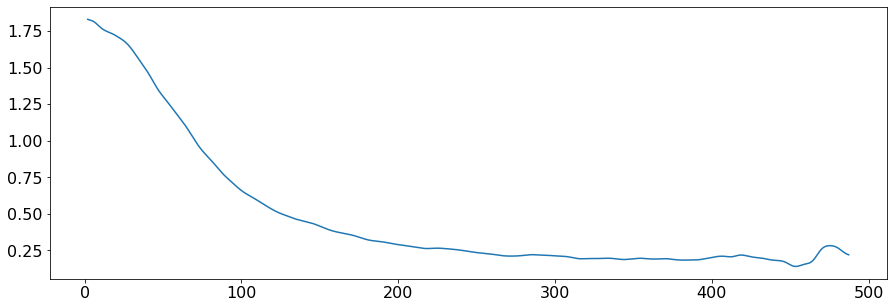

In [45]:
x, y = kernelSmooth(distance_x, distance_y)

x, y = kernelSmooth(angle_x, angle_y)
plt.plot(x, y)

In [40]:
max(x)

tensor(482.4458)

tensor(1.) tensor(1.)
tensor(1.) tensor(1.)
tensor(1.) tensor(1.)
tensor(1.) tensor(1.)
tensor(1.) tensor(1.)
tensor(1.) tensor(1.)
tensor(0.6345) tensor(1.)
tensor(0.6352) tensor(1.)
tensor(0.6332) tensor(1.)
tensor(0.6404) tensor(1.)
tensor(0.6353) tensor(1.)
tensor(0.6318) tensor(1.)


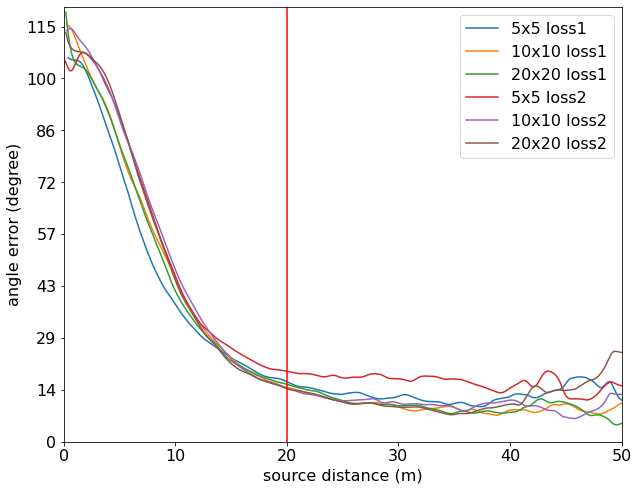

In [16]:
new_losses = [False, False, False, True, True, True]
map_xs = [5, 10, 20, 5, 10, 20]
regularizer_constants = [0, 0, 0, 0, 0, 0]
insides = [(1,3) for i in range(6)]

fig = plt.figure(figsize = (10, 8))

ax = fig.add_subplot(1, 1, 1)
labels = ["5x5 loss1", "10x10 loss1", "20x20 loss1", "5x5 loss2", "10x10 loss2", "20x20 loss2"]
# labels = ["5x5", "10x10", "20x20"]
for i in range(len(new_losses)):
    new_loss, map_x, regularizer_constant, inside = new_losses[i], map_xs[i], regularizer_constants[i], insides[i]
    x, y = getPlot(new_loss, map_x, regularizer_constant, inside, distance=False)
    
    ax.plot(x,y, label = labels[i])

ax.set_xlabel("source distance (m)")
ax.set_ylabel("angle error (degree)")

ax.set_ylim(0, np.pi* 2/3)
ax.set_xlim(0, 500)
ax.axvline(x = 200, color = 'r')

ticks_x = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format((x * 0.1)))
ax.xaxis.set_major_formatter(ticks_x)

ticks_y = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(np.round(x *180/np.pi)))
ax.yaxis.set_major_formatter(ticks_y)

plt.legend()

tensor(1.) tensor(1.)
tensor(1.) tensor(1.)
tensor(1.) tensor(1.)
tensor(1.) tensor(1.)
tensor(1.) tensor(1.)
tensor(1.) tensor(1.)
tensor(0.6345) tensor(1.)
tensor(0.6352) tensor(1.)
tensor(0.6332) tensor(1.)
tensor(0.6404) tensor(1.)
tensor(0.6353) tensor(1.)
tensor(0.6318) tensor(1.)


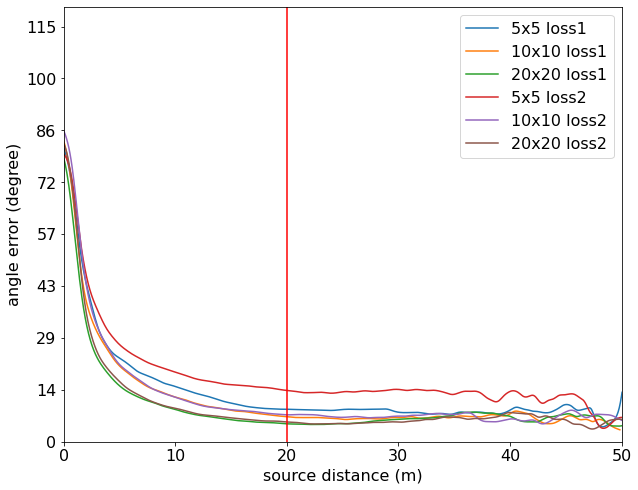

In [17]:
new_losses = [False, False, False, True, True, True]
map_xs = [5, 10, 20, 5, 10, 20]
regularizer_constants = [0, 0, 0, 0, 0, 0]
insides = [(0,2) for i in range(6)]

fig = plt.figure(figsize = (10, 8))

ax = fig.add_subplot(1, 1, 1)
labels = ["5x5 loss1", "10x10 loss1", "20x20 loss1", "5x5 loss2", "10x10 loss2", "20x20 loss2"]
# labels = ["5x5", "10x10", "20x20"]
for i in range(len(new_losses)):
    new_loss, map_x, regularizer_constant, inside = new_losses[i], map_xs[i], regularizer_constants[i], insides[i]
    x, y = getPlot(new_loss, map_x, regularizer_constant, inside, distance=False)
    
    ax.plot(x,y, label = labels[i])

ax.set_xlabel("source distance (m)")
ax.set_ylabel("angle error (degree)")

ax.set_ylim(0, np.pi* 2/3)
ax.set_xlim(0, 500)
ax.axvline(x = 200, color = 'r')

ticks_x = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format((x * 0.1)))
ax.xaxis.set_major_formatter(ticks_x)

ticks_y = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(np.round(x *180/np.pi)))
ax.yaxis.set_major_formatter(ticks_y)

plt.legend()

tensor(1.) tensor(1.)
tensor(1.) tensor(1.)
tensor(1.) tensor(1.)
tensor(1.) tensor(1.)
tensor(1.) tensor(1.)
tensor(1.) tensor(1.)
tensor(0.6345) tensor(1.)
tensor(0.6352) tensor(1.)
tensor(0.6332) tensor(1.)
tensor(0.6404) tensor(1.)
tensor(0.6353) tensor(1.)
tensor(0.6318) tensor(1.)


OutOfMemoryError: CUDA out of memory. Tried to allocate 20.00 MiB (GPU 0; 8.00 GiB total capacity; 7.01 GiB already allocated; 0 bytes free; 7.29 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

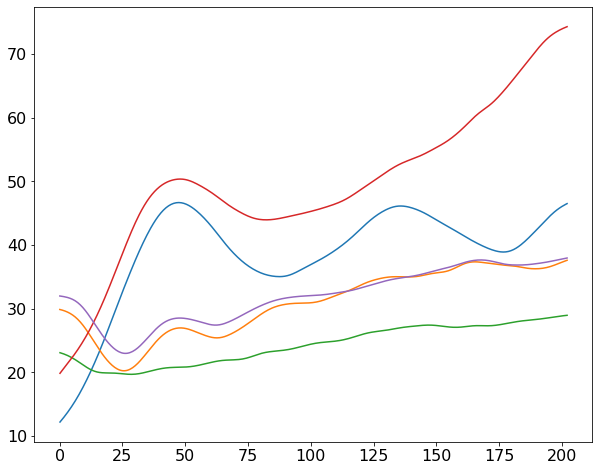

In [20]:
new_losses = [False, False, False, True, True, True]
map_xs = [5, 10, 20, 5, 10, 20]
regularizer_constants = [0, 0, 0, 0, 0, 0]
insides = [0 for i in range(6)]

fig = plt.figure(figsize = (10, 8))

ax = fig.add_subplot(1, 1, 1)
labels = ["5x5 loss1", "10x10 loss1", "20x20 loss1", "5x5 loss2", "10x10 loss2", "20x20 loss2"]
# labels = ["5x5", "10x10", "20x20"]
for i in range(len(new_losses)):
    new_loss, map_x, regularizer_constant, inside = new_losses[i], map_xs[i], regularizer_constants[i], insides[i]
    x, y = getPlot(new_loss, map_x, regularizer_constant, inside)
    
    ax.plot(x,y, label = labels[i])

ax.set_xlabel("source distance (m)")
ax.set_ylabel("distance error (m)")

ax.set_ylim(0, 140)
# ax.set_xlim(0, 500)
# ax.axvline(x = 200, color = 'r')

ticks_x = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format((x * 0.1)))
ax.xaxis.set_major_formatter(ticks_x)

ticks_y = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format((x * 0.1)))
ax.yaxis.set_major_formatter(ticks_y)

plt.legend()

tensor(1.) tensor(1.)
tensor(1.) tensor(1.)
tensor(1.) tensor(1.)
tensor(1.) tensor(1.)
tensor(1.) tensor(1.)
tensor(1.) tensor(1.)
tensor(0.6345) tensor(1.)
tensor(0.6352) tensor(1.)
tensor(0.6332) tensor(1.)
tensor(0.6404) tensor(1.)
tensor(0.6353) tensor(1.)
tensor(0.6318) tensor(1.)


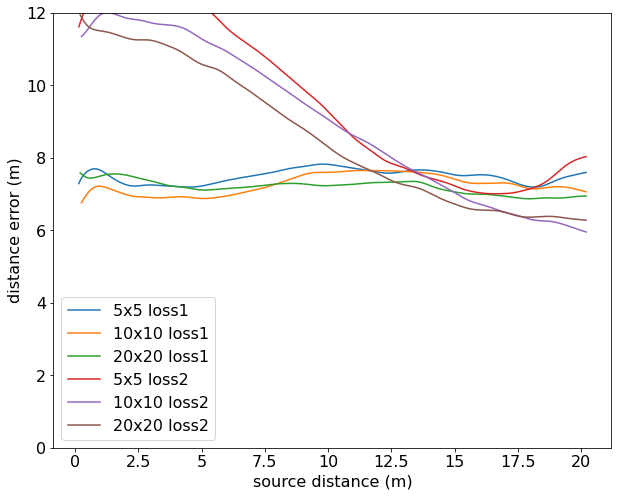

In [ ]:
new_losses = [False, False, False, True, True, True]
map_xs = [5, 10, 20, 5, 10, 20]
regularizer_constants = [0, 0, 0, 0, 0, 0]
insides = [1 for i in range(6)]

fig = plt.figure(figsize = (10, 8))

ax = fig.add_subplot(1, 1, 1)
labels = ["5x5 loss1", "10x10 loss1", "20x20 loss1", "5x5 loss2", "10x10 loss2", "20x20 loss2"]
# labels = ["5x5", "10x10", "20x20"]
for i in range(len(new_losses)):
    new_loss, map_x, regularizer_constant, inside = new_losses[i], map_xs[i], regularizer_constants[i], insides[i]
    x, y = getPlot(new_loss, map_x, regularizer_constant, inside)
    
    ax.plot(x,y, label = labels[i])

ax.set_xlabel("source distance (m)")
ax.set_ylabel("distance error (m)")

ax.set_ylim(0, 140)
# ax.set_xlim(0, 500)
# ax.axvline(x = 200, color = 'r')

ticks_x = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format((x * 0.1)))
ax.xaxis.set_major_formatter(ticks_x)

ticks_y = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format((x * 0.1)))
ax.yaxis.set_major_formatter(ticks_y)

plt.legend()

In [50]:
x

tensor([ 0.2143,  0.7956,  1.3770,  1.9583,  2.5396,  3.1210,  3.7023,  4.2836,
         4.8650,  5.4463,  6.0276,  6.6090,  7.1903,  7.7717,  8.3530,  8.9343,
         9.5157, 10.0970])

tensor(1.) tensor(1.)
tensor(1.) tensor(1.)
tensor(1.) tensor(1.)
tensor(1.) tensor(1.)
tensor(1.) tensor(1.)
tensor(1.) tensor(1.)
tensor(0.6375) tensor(1.)
tensor(0.6230) tensor(1.)
tensor(0.6339) tensor(1.)
tensor(0.6374) tensor(1.)
tensor(0.6352) tensor(1.)
tensor(0.6324) tensor(1.)


OutOfMemoryError: CUDA out of memory. Tried to allocate 20.00 MiB (GPU 0; 8.00 GiB total capacity; 7.01 GiB already allocated; 0 bytes free; 7.29 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

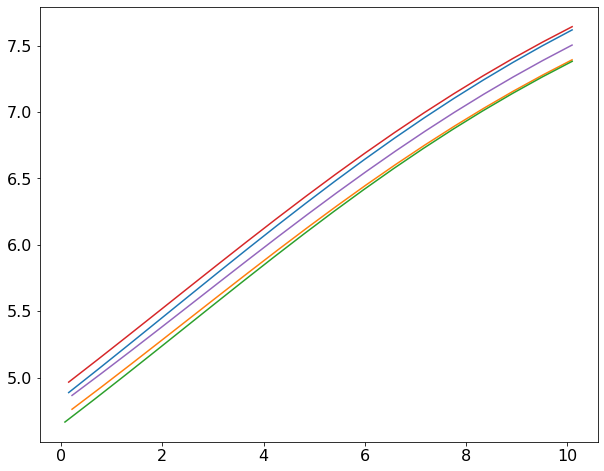

In [47]:
new_losses = [False, False, False, True, True, True]
map_xs = [5, 10, 20, 5, 10, 20]
regularizer_constants = [0, 0, 0, 0, 0, 0]
insides = [0 for i in range(6)]

fig = plt.figure(figsize = (10, 8))

ax = fig.add_subplot(1, 1, 1)
labels = ["5x5 loss1", "10x10 loss1", "20x20 loss1", "5x5 loss2", "10x10 loss2", "20x20 loss2"]
# labels = ["5x5", "10x10", "20x20"]
for i in range(len(new_losses)):
    new_loss, map_x, regularizer_constant, inside = new_losses[i], map_xs[i], regularizer_constants[i], insides[i]
    x, y = getPlot(new_loss, map_x, regularizer_constant, inside)
    
    ax.plot(x,y, label = labels[i])

ax.set_xlabel("source distance (m)")
ax.set_ylabel("distance error (m)")
# ax.set_ylim(0, 130)
ticks_x = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format((x * 0.1)))
ax.xaxis.set_major_formatter(ticks_x)

ticks_x = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format((x * 0.1)))
ax.yaxis.set_major_formatter(ticks_x)

plt.legend()

tensor(1.) tensor(1.)
tensor(1.) tensor(1.)
tensor(1.) tensor(1.)
tensor(1.) tensor(1.)
tensor(1.) tensor(1.)
tensor(1.) tensor(1.)
tensor(0.6375) tensor(1.)
tensor(0.6230) tensor(1.)
tensor(0.6339) tensor(1.)
tensor(0.6374) tensor(1.)
tensor(0.6352) tensor(1.)
tensor(0.6324) tensor(1.)


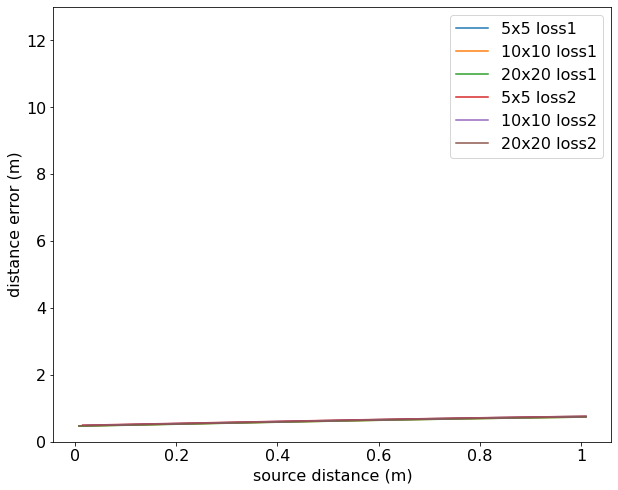

In [17]:
new_losses = [False, False, False, True, True, True]
map_xs = [5, 10, 20, 5, 10, 20]
regularizer_constants = [0, 0, 0, 0, 0, 0]
insides = [0 for i in range(6)]

fig = plt.figure(figsize = (10, 8))

ax = fig.add_subplot(1, 1, 1)
labels = ["5x5 loss1", "10x10 loss1", "20x20 loss1", "5x5 loss2", "10x10 loss2", "20x20 loss2"]
# labels = ["5x5", "10x10", "20x20"]
for i in range(len(new_losses)):
    new_loss, map_x, regularizer_constant, inside = new_losses[i], map_xs[i], regularizer_constants[i], insides[i]
    x, y = getPlot(new_loss, map_x, regularizer_constant, inside)
    
    ax.plot(x,y, label = labels[i])

ax.set_xlabel("source distance (m)")
ax.set_ylabel("distance error (m)")
ax.set_ylim(0, 130)
ticks_x = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format((x * 0.1)))
ax.xaxis.set_major_formatter(ticks_x)

ticks_x = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format((x * 0.1)))
ax.yaxis.set_major_formatter(ticks_x)

plt.legend()

In [18]:
x

tensor([ 0.0742,  0.6640,  1.2537,  1.8435,  2.4332,  3.0230,  3.6127,  4.2025,
         4.7922,  5.3820,  5.9717,  6.5615,  7.1512,  7.7410,  8.3307,  8.9205,
         9.5102, 10.1000])

In [19]:
y

tensor([4.7560, 4.9281, 5.1036, 5.2815, 5.4607, 5.6401, 5.8186, 5.9952, 6.1688,
        6.3383, 6.5031, 6.6624, 6.8156, 6.9622, 7.1020, 7.2348, 7.3605, 7.4791])

tensor(1.) tensor(1.)
tensor(1.) tensor(1.)
tensor(1.) tensor(1.)
tensor(1.) tensor(1.)
tensor(0.6332) tensor(1.)
tensor(0.6404) tensor(1.)
tensor(0.6332) tensor(1.)
tensor(0.6404) tensor(1.)


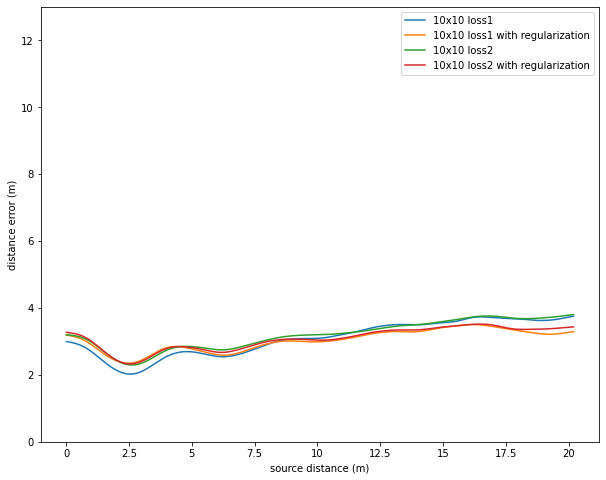

In [14]:
new_losses = [False, False, True, True]
map_xs = [10, 10, 10, 10]
regularizer_constants = [0, 0.01, 0, 0.01]
insides = [0, 0, 0, 0]

fig = plt.figure(figsize = (10, 8))

ax = fig.add_subplot(1, 1, 1)
labels = ["10x10 loss1", "10x10 loss1 with regularization", "10x10 loss2", "10x10 loss2 with regularization"]
for i in range(len(new_losses)):
    new_loss, map_x, regularizer_constant, inside = new_losses[i], map_xs[i], regularizer_constants[i], insides[i]
    x, y = getPlot(new_loss, map_x, regularizer_constant, inside)
    
    ax.plot(x,y, label = labels[i])

ax.set_xlabel("source distance (m)")
ax.set_ylabel("distance error (m)")
ax.set_ylim(0, 130)
ticks_x = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format((x * 0.1)))
ax.xaxis.set_major_formatter(ticks_x)

ticks_x = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format((x * 0.1)))
ax.yaxis.set_major_formatter(ticks_x)

plt.legend()

tensor(1.) tensor(1.)
tensor(1.) tensor(1.)
tensor(1.) tensor(1.)
tensor(1.) tensor(1.)
tensor(0.6332) tensor(1.)
tensor(0.6404) tensor(1.)
tensor(0.6332) tensor(1.)
tensor(0.6404) tensor(1.)


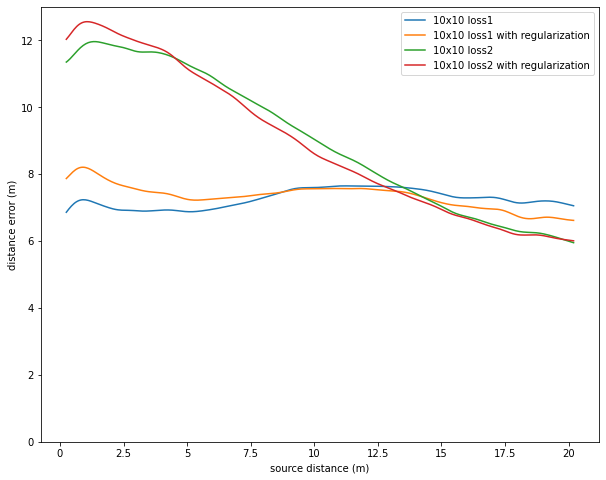

In [15]:
new_losses = [False, False, True, True]
map_xs = [10, 10, 10, 10]
regularizer_constants = [0, 0.01, 0, 0.01]
insides = [1 for i in range(len(new_losses))]

fig = plt.figure(figsize = (10, 8))

ax = fig.add_subplot(1, 1, 1)
labels = ["10x10 loss1", "10x10 loss1 with regularization", "10x10 loss2", "10x10 loss2 with regularization"]
for i in range(len(new_losses)):
    new_loss, map_x, regularizer_constant, inside = new_losses[i], map_xs[i], regularizer_constants[i], insides[i]
    x, y = getPlot(new_loss, map_x, regularizer_constant, inside)
    
    ax.plot(x,y, label = labels[i])

ax.set_xlabel("source distance (m)")
ax.set_ylabel("distance error (m)")
ax.set_ylim(0, 130)
ticks_x = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format((x * 0.1)))
ax.xaxis.set_major_formatter(ticks_x)

ticks_x = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format((x * 0.1)))
ax.yaxis.set_major_formatter(ticks_x)

plt.legend()

tensor(1.) tensor(1.)
tensor(1.) tensor(1.)
tensor(1.) tensor(1.)
tensor(1.) tensor(1.)
tensor(0.6332) tensor(1.)
tensor(0.6404) tensor(1.)
tensor(0.6332) tensor(1.)
tensor(0.6404) tensor(1.)


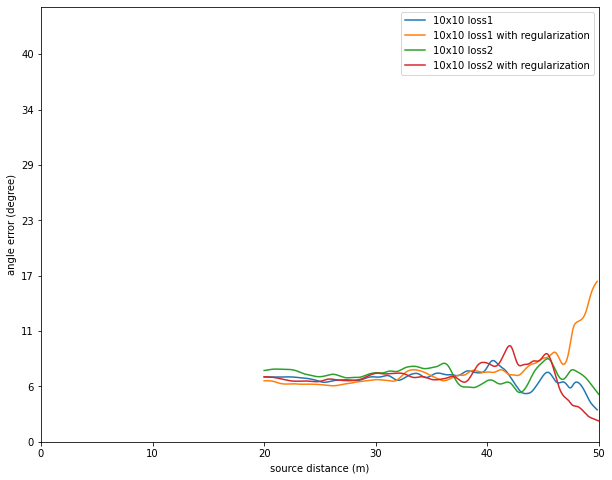

In [16]:
new_losses = [False, False, True, True]
map_xs = [10, 10, 10, 10]
regularizer_constants = [0, 0.01, 0, 0.01]
insides = [2 for i in range(len(new_losses))]

fig = plt.figure(figsize = (10, 8))

ax = fig.add_subplot(1, 1, 1)
labels = ["10x10 loss1", "10x10 loss1 with regularization", "10x10 loss2", "10x10 loss2 with regularization"]
for i in range(len(new_losses)):
    new_loss, map_x, regularizer_constant, inside = new_losses[i], map_xs[i], regularizer_constants[i], insides[i]
    x, y = getPlot(new_loss, map_x, regularizer_constant, inside, distance=False)
    
    ax.plot(x,y, label = labels[i])

ax.set_xlabel("source distance (m)")
ax.set_ylabel("angle error (degree)")

ax.set_ylim(0, np.pi/4)
ax.set_xlim(0, 500)
ticks_x = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format((x * 0.1)))
ax.xaxis.set_major_formatter(ticks_x)

ticks_y = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(np.round(x *180/np.pi)))
ax.yaxis.set_major_formatter(ticks_y)

plt.legend()

tensor(1.) tensor(1.)
tensor(1.) tensor(1.)
tensor(1.) tensor(1.)
tensor(1.) tensor(1.)
tensor(0.6332) tensor(1.)
tensor(0.6404) tensor(1.)
tensor(0.6332) tensor(1.)
tensor(0.6404) tensor(1.)


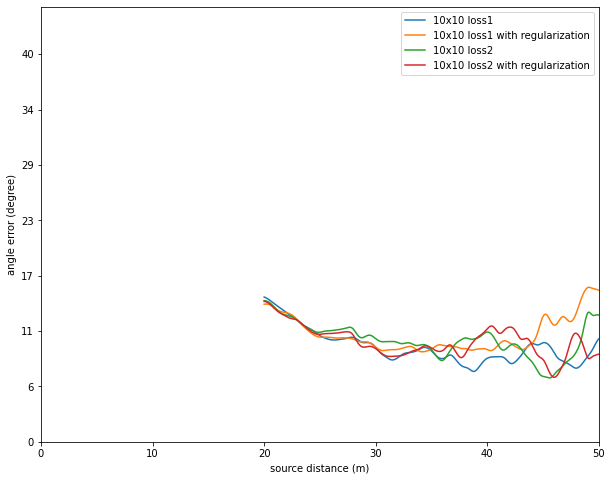

: 

In [17]:
new_losses = [False, False, True, True]
map_xs = [10, 10, 10, 10]
regularizer_constants = [0, 0.01, 0, 0.01]
insides = [3 for i in range(len(new_losses))]

fig = plt.figure(figsize = (10, 8))

ax = fig.add_subplot(1, 1, 1)
labels = ["10x10 loss1", "10x10 loss1 with regularization", "10x10 loss2", "10x10 loss2 with regularization"]
for i in range(len(new_losses)):
    new_loss, map_x, regularizer_constant, inside = new_losses[i], map_xs[i], regularizer_constants[i], insides[i]
    x, y = getPlot(new_loss, map_x, regularizer_constant, inside, distance=False)
    
    ax.plot(x,y, label = labels[i])

ax.set_xlabel("source distance (m)")
ax.set_ylabel("angle error (degree)")

ax.set_ylim(0, np.pi/4)
ax.set_xlim(0, 500)
ticks_x = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format((x * 0.1)))
ax.xaxis.set_major_formatter(ticks_x)

ticks_y = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(np.round(x *180/np.pi)))
ax.yaxis.set_major_formatter(ticks_y)

plt.legend()

tensor(1.) tensor(1.)
tensor(1.) tensor(1.)
tensor(1.) tensor(1.)
tensor(1.) tensor(1.)


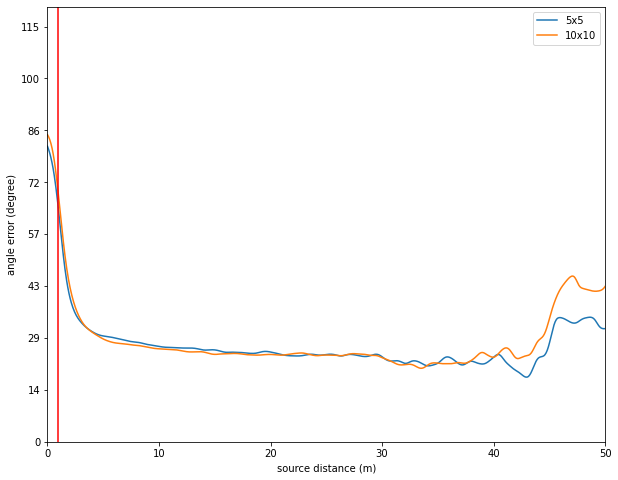

In [10]:
new_losses = [False, False]
map_xs = [5, 10, 20, 5, 10, 20]
regularizer_constants = [0, 0, 0, 0, 0, 0]
insides = [(0,2) for i in range(6)]

fig = plt.figure(figsize = (10, 8))

ax = fig.add_subplot(1, 1, 1)
labels = ["5x5", "10x10", "20x20 loss1", "5x5 loss2", "10x10 loss2", "20x20 loss2"]
# labels = ["5x5", "10x10", "20x20"]
for i in range(len(new_losses)):
    new_loss, map_x, regularizer_constant, inside = new_losses[i], map_xs[i], regularizer_constants[i], insides[i]
    x, y = getPlot(new_loss, map_x, regularizer_constant, inside, distance=False)
    
    ax.plot(x,y, label = labels[i])

ax.set_xlabel("source distance (m)")
ax.set_ylabel("angle error (degree)")

ax.set_ylim(0, np.pi* 2/3)
ax.set_xlim(0, 500)
ax.axvline(x = 10, color = 'r')

ticks_x = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format((x * 0.1)))
ax.xaxis.set_major_formatter(ticks_x)

ticks_y = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(np.round(x *180/np.pi)))
ax.yaxis.set_major_formatter(ticks_y)

plt.legend()

tensor(1.) tensor(1.)
tensor(1.) tensor(1.)
tensor(1.) tensor(1.)
tensor(1.) tensor(1.)


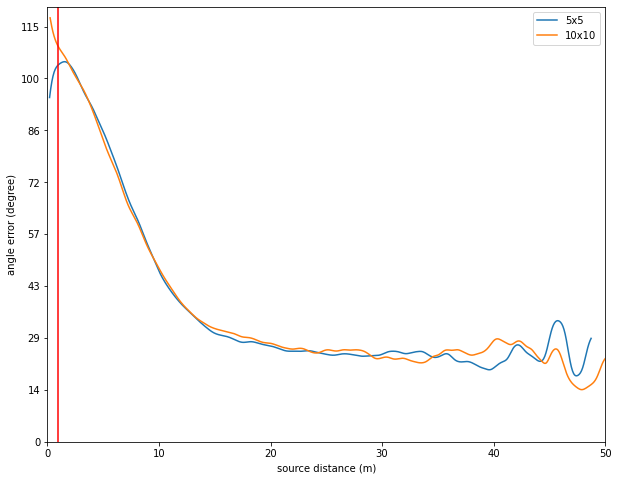

In [11]:
new_losses = [False, False]
map_xs = [5, 10, 20, 5, 10, 20]
regularizer_constants = [0, 0, 0, 0, 0, 0]
insides = [(1,3) for i in range(6)]

fig = plt.figure(figsize = (10, 8))

ax = fig.add_subplot(1, 1, 1)
labels = ["5x5", "10x10", "20x20 loss1", "5x5 loss2", "10x10 loss2", "20x20 loss2"]
# labels = ["5x5", "10x10", "20x20"]
for i in range(len(new_losses)):
    new_loss, map_x, regularizer_constant, inside = new_losses[i], map_xs[i], regularizer_constants[i], insides[i]
    x, y = getPlot(new_loss, map_x, regularizer_constant, inside, distance=False)
    
    ax.plot(x,y, label = labels[i])

ax.set_xlabel("source distance (m)")
ax.set_ylabel("angle error (degree)")

ax.set_ylim(0, np.pi* 2/3)
ax.set_xlim(0, 500)
ax.axvline(x = 10, color = 'r')

ticks_x = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format((x * 0.1)))
ax.xaxis.set_major_formatter(ticks_x)

ticks_y = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(np.round(x *180/np.pi)))
ax.yaxis.set_major_formatter(ticks_y)

plt.legend()

tensor(1.) tensor(1.)
tensor(1.) tensor(1.)


RuntimeError: indices should be either on cpu or on the same device as the indexed tensor (cpu)

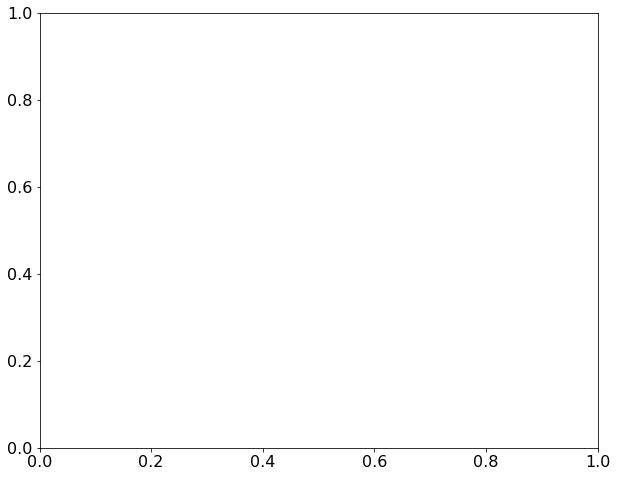

In [10]:
new_losses = [False, False, False, True, True, True]
map_xs = [5, 10, 20, 5, 10, 20]
regularizer_constants = [0, 0, 0, 0, 0, 0]
insides = [(1,3) for i in range(6)]

fig = plt.figure(figsize = (10, 8))

ax = fig.add_subplot(1, 1, 1)
labels = ["5x5 loss1", "10x10 loss1", "20x20 loss1", "5x5 loss2", "10x10 loss2", "20x20 loss2"]
# labels = ["5x5", "10x10", "20x20"]
for i in range(len(new_losses)):
    new_loss, map_x, regularizer_constant, inside = new_losses[i], map_xs[i], regularizer_constants[i], insides[i]
    x, y = getPlot(new_loss, map_x, regularizer_constant, inside, distance=False)
    
    ax.plot(x,y, label = labels[i])

ax.set_xlabel("source distance (m)")
ax.set_ylabel("angle error (degree)")

ax.set_ylim(0, np.pi* 2/3)
ax.set_xlim(0, 500)
ax.axvline(x = 200, color = 'r')

ticks_x = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format((x * 0.1)))
ax.xaxis.set_major_formatter(ticks_x)

ticks_y = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(np.round(x *180/np.pi)))
ax.yaxis.set_major_formatter(ticks_y)

plt.legend()

tensor(1.) tensor(1.)
tensor(1.) tensor(1.)
tensor(1.) tensor(1.)
tensor(1.) tensor(1.)
tensor(1.) tensor(1.)
tensor(1.) tensor(1.)
tensor(0.6345) tensor(1.)
tensor(0.6352) tensor(1.)
tensor(0.6332) tensor(1.)
tensor(0.6404) tensor(1.)
tensor(0.6353) tensor(1.)
tensor(0.6318) tensor(1.)


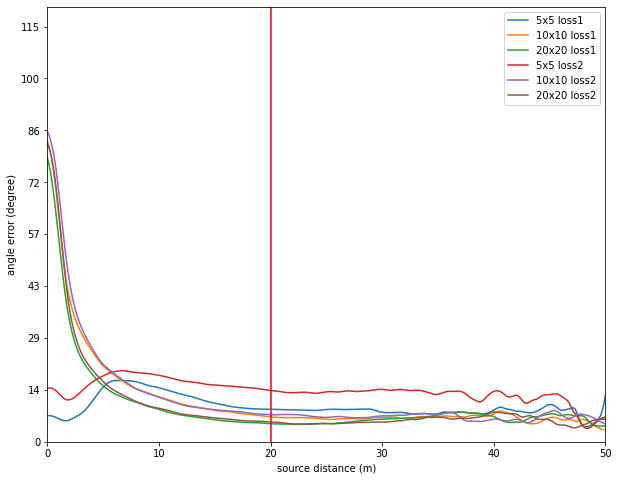

In [9]:
new_losses = [False, False, False, True, True, True]
map_xs = [5, 10, 20, 5, 10, 20]
regularizer_constants = [0, 0, 0, 0, 0, 0]
insides = [(0,2) for i in range(6)]

fig = plt.figure(figsize = (10, 8))

ax = fig.add_subplot(1, 1, 1)
labels = ["5x5 loss1", "10x10 loss1", "20x20 loss1", "5x5 loss2", "10x10 loss2", "20x20 loss2"]
# labels = ["5x5", "10x10", "20x20"]
for i in range(len(new_losses)):
    new_loss, map_x, regularizer_constant, inside = new_losses[i], map_xs[i], regularizer_constants[i], insides[i]
    x, y = getPlot(new_loss, map_x, regularizer_constant, inside, distance=False)
    
    ax.plot(x,y, label = labels[i])

ax.set_xlabel("source distance (m)")
ax.set_ylabel("angle error (degree)")

ax.set_ylim(0, np.pi* 2/3)
ax.set_xlim(0, 500)
ax.axvline(x = 200, color = 'r')

ticks_x = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format((x * 0.1)))
ax.xaxis.set_major_formatter(ticks_x)

ticks_y = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(np.round(x *180/np.pi)))
ax.yaxis.set_major_formatter(ticks_y)

plt.legend()

tensor(1.) tensor(1.)
tensor(1.) tensor(1.)
tensor(1.) tensor(1.)
tensor(1.) tensor(1.)
tensor(1.) tensor(1.)
tensor(1.) tensor(1.)
tensor(0.6345) tensor(1.)
tensor(0.6352) tensor(1.)
tensor(0.6332) tensor(1.)
tensor(0.6404) tensor(1.)


RuntimeError: CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 8.00 GiB total capacity; 4.01 GiB already allocated; 0 bytes free; 6.26 GiB reserved in total by PyTorch)

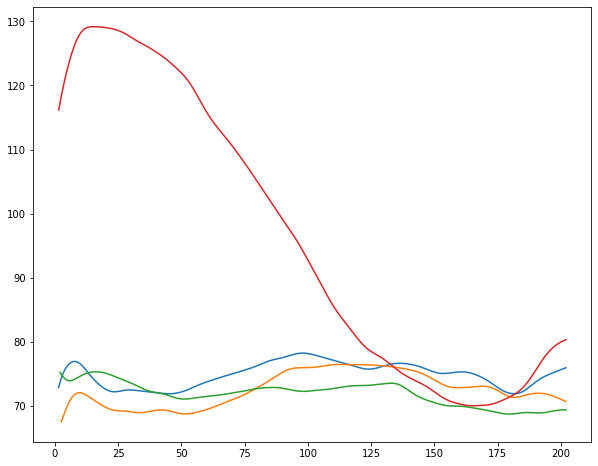

In [8]:
new_losses = [False, False, False, True, True, True]
map_xs = [5, 10, 20, 5, 10, 20]
regularizer_constants = [0, 0, 0, 0, 0, 0]
insides = [1 for i in range(6)]

fig = plt.figure(figsize = (10, 8))

ax = fig.add_subplot(1, 1, 1)
labels = ["5x5 loss1", "10x10 loss1", "20x20 loss1", "5x5 loss2", "10x10 loss2", "20x20 loss2"]
# labels = ["5x5", "10x10", "20x20"]
for i in range(len(new_losses)):
    new_loss, map_x, regularizer_constant, inside = new_losses[i], map_xs[i], regularizer_constants[i], insides[i]
    x, y = getPlot(new_loss, map_x, regularizer_constant, inside)
    
    ax.plot(x,y, label = labels[i])

ax.set_xlabel("source distance (m)")
ax.set_ylabel("distance error (m)")
ax.set_ylim(0, 130)
ticks_x = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format((x * 0.1)))
ax.xaxis.set_major_formatter(ticks_x)

ticks_x = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format((x * 0.1)))
ax.yaxis.set_major_formatter(ticks_x)

plt.legend()

tensor(1.) tensor(1.)
tensor(1.) tensor(1.)
tensor(1.) tensor(1.)
tensor(1.) tensor(1.)
tensor(1.) tensor(1.)
tensor(1.) tensor(1.)


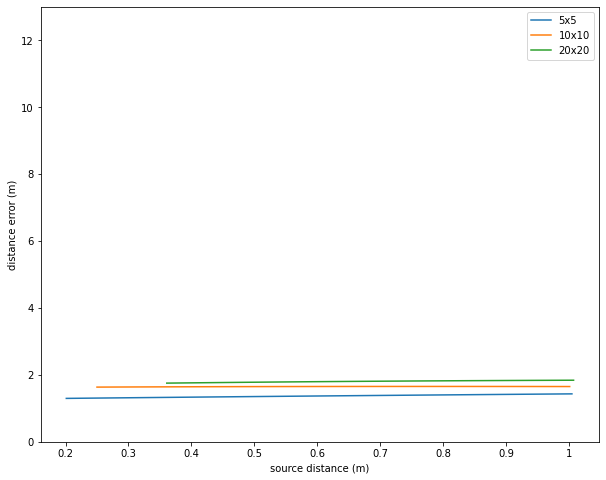

In [10]:
new_losses = [False, False, False] #, True, True, True]
map_xs = [5, 10, 20, 5, 10, 20]
regularizer_constants = [0, 0, 0, 0, 0, 0]
insides = [1, 1, 1, 1, 1, 1]

fig = plt.figure(figsize = (10, 8))

ax = fig.add_subplot(1, 1, 1)
labels = ["5x5 loss1", "10x10 loss1", "20x20 loss1", "5x5 loss2", "10x10 loss2", "20x20 loss2"]
labels = ["5x5", "10x10", "20x20"]
for i in range(len(new_losses)):
    new_loss, map_x, regularizer_constant, inside = new_losses[i], map_xs[i], regularizer_constants[i], insides[i]
    x, y = getPlot(new_loss, map_x, regularizer_constant, inside)
    
    ax.plot(x,y, label = labels[i])

ax.set_ylim(0, 130)
ax.set_xlabel("source distance (m)")
ax.set_ylabel("distance error (m)")
ticks_x = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format((x * 0.1)))
ax.xaxis.set_major_formatter(ticks_x)

ticks_x = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format((x * 0.1)))
ax.yaxis.set_major_formatter(ticks_x)

plt.legend()

tensor(1.) tensor(1.)
tensor(1.) tensor(1.)
tensor(1.) tensor(1.)
tensor(1.) tensor(1.)
tensor(1.) tensor(1.)
tensor(1.) tensor(1.)


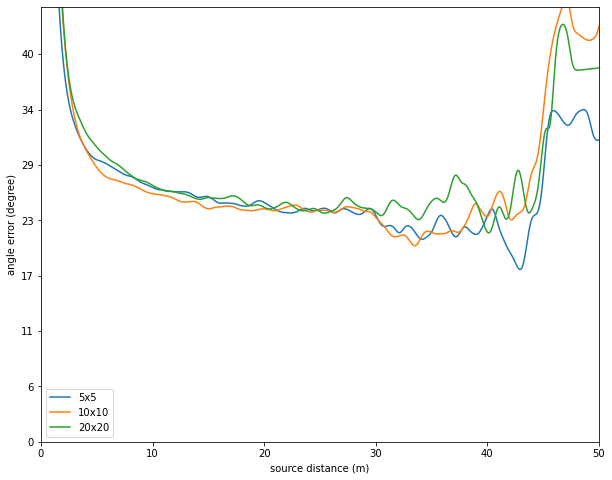

In [11]:
new_losses = [False, False, False] #, True, True, True]
map_xs = [5, 10, 20, 5, 10, 20]
regularizer_constants = [0, 0, 0, 0, 0, 0]
insides = [(0,2) for i in range(6)]

fig = plt.figure(figsize = (10, 8))

ax = fig.add_subplot(1, 1, 1)
labels = ["5x5 loss1", "10x10 loss1", "20x20 loss1", "5x5 loss2", "10x10 loss2", "20x20 loss2"]
labels = ["5x5", "10x10", "20x20"]
for i in range(len(new_losses)):
    new_loss, map_x, regularizer_constant, inside = new_losses[i], map_xs[i], regularizer_constants[i], insides[i]
    x, y = getPlot(new_loss, map_x, regularizer_constant, inside, distance=False)
    
    ax.plot(x,y, label = labels[i])

ax.set_xlabel("source distance (m)")
ax.set_ylabel("angle error (degree)")

ax.set_ylim(0, np.pi/4)
ax.set_xlim(0, 500)
ticks_x = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format((x * 0.1)))
ax.xaxis.set_major_formatter(ticks_x)

ticks_y = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(np.round(x *180/np.pi)))
ax.yaxis.set_major_formatter(ticks_y)

plt.legend()

tensor(1.) tensor(1.)
tensor(1.) tensor(1.)
tensor(1.) tensor(1.)
tensor(1.) tensor(1.)
tensor(1.) tensor(1.)
tensor(1.) tensor(1.)


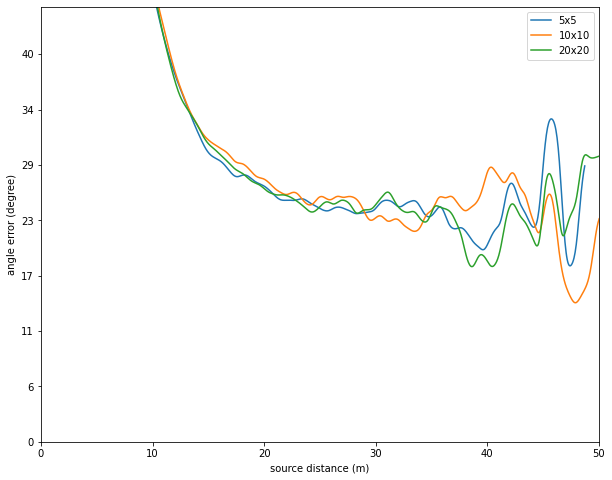

In [12]:
new_losses = [False, False, False] #, True, True, True]
map_xs = [5, 10, 20, 5, 10, 20]
regularizer_constants = [0, 0, 0, 0, 0, 0]
insides = [(1,3) for i in range(6)]

fig = plt.figure(figsize = (10, 8))

ax = fig.add_subplot(1, 1, 1)
labels = ["5x5 loss1", "10x10 loss1", "20x20 loss1", "5x5 loss2", "10x10 loss2", "20x20 loss2"]
labels = ["5x5", "10x10", "20x20"]
for i in range(len(new_losses)):
    new_loss, map_x, regularizer_constant, inside = new_losses[i], map_xs[i], regularizer_constants[i], insides[i]
    x, y = getPlot(new_loss, map_x, regularizer_constant, inside, distance=False)
    
    ax.plot(x,y, label = labels[i])

ax.set_xlabel("source distance (m)")
ax.set_ylabel("angle error (degree)")

ax.set_ylim(0, np.pi/4)
ax.set_xlim(0, 500)
ticks_x = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format((x * 0.1)))
ax.xaxis.set_major_formatter(ticks_x)

ticks_y = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(np.round(x *180/np.pi)))
ax.yaxis.set_major_formatter(ticks_y)

plt.legend()

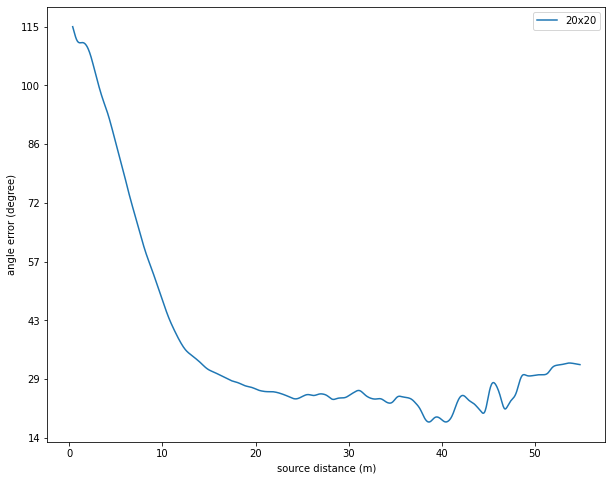

In [14]:
fig = plt.figure(figsize = (10, 8))

ax = fig.add_subplot(1, 1, 1)

ax.plot(x,y, label = labels[i])

ax.set_xlabel("source distance (m)")
ax.set_ylabel("angle error (degree)")

# ax.set_ylim(0, np.pi/4)
# ax.set_xlim(0, 500)
ticks_x = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format((x * 0.1)))
ax.xaxis.set_major_formatter(ticks_x)

ticks_y = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(np.round(x *180/np.pi)))
ax.yaxis.set_major_formatter(ticks_y)

plt.legend()

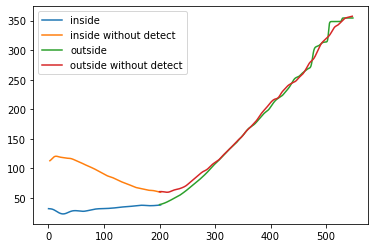

In [11]:


evaluate_labels = ["inside", "inside without detect", "outside", "outside without detect"]
for i in range (4):
    evaluate_mask = (mask[i] ).type(torch.bool)
    evaluate_x = source_distance[evaluate_mask]
    
    evaluate_y = error_distance[evaluate_mask]
    x, y = kernelSmooth(evaluate_x, evaluate_y)

    plt.plot(x, y, label = evaluate_labels[i])
plt.legend()

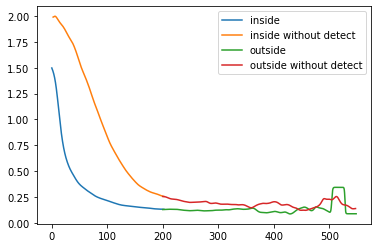

In [12]:
evaluate_labels = ["inside", "inside without detect", "outside", "outside without detect"]
for i in range (4):
    evaluate_mask = (mask[i] ).type(torch.bool)
    evaluate_x = source_distance[evaluate_mask]
    evaluate_y = error_angle[evaluate_mask]
    x, y = kernelSmooth(evaluate_x, evaluate_y)
    plt.plot(x, y, label = evaluate_labels[i])
plt.legend()

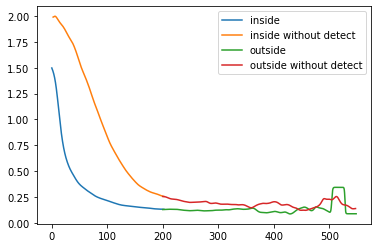

In [13]:
evaluate_labels = ["inside", "inside without detect", "outside", "outside without detect"]
for i in range (4):
    
    evaluate_mask = (mask[i]).type(torch.bool) #if i % 2 == 1 else (mask[i] * valid).type(torch.bool)
    
    evaluate_x = source_distance[evaluate_mask]
    evaluate_y = error_angle[evaluate_mask]
    x, y = kernelSmooth(evaluate_x, evaluate_y)
    plt.plot(x, y, label = evaluate_labels[i])
plt.legend()

In [48]:
for i in range(4):
    print(torch.sum(mask[i]) - torch.sum(mask[i] * valid))

tensor(0.)
tensor(163393.)
tensor(0.)
tensor(26469.)


In [9]:
temp_source_distance = torch.cdist(source_pos, torch.tensor([[0, 0]], dtype=torch.float)).squeeze(-1)

temp = torch.abs(source_inside - (temp_source_distance<=200).type(torch.long))
torch.sum(temp)

tensor(0.)

In [20]:
temp = torch.abs(source_inside - (source_distance<=200).type(torch.long))
# temp = source_inside - (source_distance<=200).type(torch.long)
torch.sum(temp)

tensor(105678.)

In [8]:
source_distance.shape

torch.Size([4400, 120])

tensor(0.)

In [46]:
X_input_cum_sum = torch.cumsum(X_input[..., 0] > 0, dim=-1)
X_input_cum_sum[:, -1] = 1
torch.sum((X_input_cum_sum>0).type(torch.long) - valid.type(torch.long))

tensor(0)

In [47]:
X_input_cum_sum.shape

torch.Size([4400, 120])

In [ ]:
X_input_cum_sum = torch.cumsum(X_input[..., 0] > 0, dim=-1)

In [37]:
torch.sum(valid.type(torch.long) - source_detect)

tensor(927.)

In [42]:
torch.sum(torch.sum(valid, dim=-1)== 1)

tensor(929)

In [13]:
def getObservation(self):
    def agentDetect(source, agent):
        packets_position, packets_concentration = source.packets_position, source.packets_concentration
        # position.shape = (n_packet, 2); concentration.shape = (n_packet, 1)

        # check position_mask
        position_mask = np.ones(len(packets_position)).astype(np.bool)
        for i_axis in range(packets_position.shape[1]):
            min_range, max_range = agent.position[i_axis] - agent.radius, agent.position[i_axis] + agent.radius
            axis_mask = (packets_position[:, i_axis] <= max_range) & (packets_position[:, i_axis] >= min_range)
            position_mask = position_mask * axis_mask

        # apply mask to find total/ average concentration
        try:
            detected_packets_concentration = packets_concentration[position_mask]
        except:
            print(packets_position.shape, axis_mask.shape)
            print(position_mask.shape)
            quit()

        total_concentration = np.sum(detected_packets_concentration)
        avg_concentration = total_concentration / (
                len(detected_packets_concentration) + (len(detected_packets_concentration) == 0))
        return total_concentration, avg_concentration

    # observation = (total_concentration, water_flow_force)
    agent_water_flow_force = self.wind.getTurbulenceVector(self.agent.position[np.newaxis, ...], self.t)  # (1,2)
    total_concen, avg_concen = agentDetect(self.source, self.agent)
    total_concen, avg_concen = np.atleast_2d(total_concen), np.atleast_2d(avg_concen)  # (1, 1)

    obs = np.concatenate((total_concen, agent_water_flow_force), axis=-1)  # (1,3)

    # generate data purpose
    self.detect_total_concentration = total_concen
    self.detect_avg_concentration = avg_concen
    self.detect_water_flow_force = agent_water_flow_force
    if total_concen > 0: self.detect_source = 1

    self.source_concentration = self.source.concentration

    torch_obs = torch.from_numpy(obs).type(torch.float)
    return torch_obs

torch.Size([8, 3])

In [16]:
LSTM_runner.train_index.shape

(17600,)

In [17]:
LSTM_runner.test_index.shape

(17600,)

In [18]:
LSTM_runner.test_size

4400